In [1]:
# imports
import torch
from torch import nn
from torchvision.models import resnet18
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import platform
from torch.autograd import Variable
import time
from efficientnet_pytorch import EfficientNet
import glob
import os

# vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import sklearn.metrics
from math import ceil
import cv2
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import PIL

In [2]:
# import dataset
train = pd.read_csv('../input/train.csv')

## Generate Paths

In [3]:
# train directory
TRAIN_DIR = "C:\\Users\\Admin\\Git\\SIIM\\train\\"
# paths
paths = list()
# create path column
for _id in tqdm(train['StudyInstanceUID']):
    try:
        paths.append(glob.glob(os.path.join(TRAIN_DIR, _id +"/*/*"))[0])
    except:
        paths.append('')
train['path'] = paths
train.head()

100%|██████████████████████████████████████████████████████████| 6334/6334 [00:00<00:00, 9896.09it/s]


,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount,path
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,C:\Users\Admin\Git\SIIM\train\5776db0cec75\814...
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,C:\Users\Admin\Git\SIIM\train\ff0879eb20ed\d8a...
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,C:\Users\Admin\Git\SIIM\train\9d514ce429a7\228...
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,C:\Users\Admin\Git\SIIM\train\28dddc8559b2\4d4...
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,C:\Users\Admin\Git\SIIM\train\dfd9fdd85a3e\491...


In [4]:
# remove where paths not found
train = train[train.path != ''].copy()

In [5]:
# check
train[train.path == '']

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount,path


## Config

In [6]:
class Config:
    train_pcent = 0.8
    TRAIN_BS = 4
    VALID_BS = 4
    NB_EPOCHS = 4
    model_name = 'EfficientNETB2'
    reshape_size = (400, 400)
    num_classes = 4

# Dataset

In [7]:
class SIIM(Dataset):
    def __init__(self, df, is_train=True, augments=None, 
                 reshape_size=Config.reshape_size):
        super().__init__()
        # random sample data
        self.df = df.sample(frac=1).reset_index(drop=True)
        # training or validation
        self.is_train = is_train
        # augmentations
        self.augments = augments
        self.reshape_size = reshape_size
    
    @staticmethod
    def dicom2array(path, voi_lut=True, fix_monochrome=True):
        dicom = pydicom.read_file(path)
        # VOI LUT (if available by DICOM device) is used to
        # transform raw DICOM data to "human-friendly" view
        if voi_lut:
            data = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            data = dicom.pixel_array
        # depending on this value, X-ray may look inverted - fix that:
        if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        data = (data * 255).astype(np.uint8)
        return data
    
    def __getitem__(self, idx):
        # retrieve image
        image_id = self.df['StudyInstanceUID'].values[idx]
        image_path = self.df['path'].values[idx]
        # get image
        image = self.dicom2array(image_path)
        # recolour
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        # resize
        image = cv2.resize(image, self.reshape_size)
        # Augments
        if self.augments:
            image = self.augments(image=image)
        else:
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)
            image = torch.tensor(image)  
            
        # if train
        if self.is_train:
            label = self.df[self.df['StudyInstanceUID'] == image_id].values.tolist()[0][4:-2]
            return image, torch.tensor(label)

        return image
    
    def __len__(self):
        return(len(self.df))

# Model

Fake model function that should output a value of 1 for either:

<code>'negative', 'typical', 'indeterminate', 'atypical'</code>

In [8]:
class NN(nn.Module):
    def __init__(self, num_classes=4):
        super(NN, self).__init__()
        # model spec
        self.out = nn.Sigmoid()
        self.num_classes = num_classes
        
        self.convolutions = nn.Sequential(nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
                                          *(list(resnet18().children())[1:-1]))
        self.dense = nn.Linear(512, num_classes)
        
    def forward(self, X):
        # batch size
        batch_size = X.shape[0]
        # create fake data
        rand = torch.randn([batch_size, 4])
        return Variable(self.out(rand), requires_grad=True)
    
    
class EfficientNETB2(nn.Module):
    def __init__(self, NUM_CLASSES=Config.num_classes, pretrained=True):
        super(EfficientNETB2, self).__init__()
        # model
        self.NUM_CLASSES = NUM_CLASSES
        self.effnet = self.load_effnet(pretrained)
        self.effnet._fc = nn.Linear(1408, self.NUM_CLASSES)
        self.out = nn.Sigmoid()
        
    def load_effnet(self, pretrained):
        if pretrained == True:
            effnet = EfficientNet.from_pretrained("efficientnet-b2")
        else:
            effnet = EfficientNet.from_name("efficientnet-b2")
        return effnet
        
    def forward(self, X):
        X = self.effnet(X)
        output = self.out(X)
        return(output)

# Trainer

In [9]:
class Trainer:
    def __init__(self, train_dataloader, valid_dataloader, model,
                optimiser, loss_fn, val_loss_fn, device='cpu'):
        """
        Constructor for Trainer class
        """
        self.train = train_dataloader
        self.valid = valid_dataloader
        self.model = model
        self.optim = optimiser
        self.loss_fn = loss_fn
        self.val_loss_fn = val_loss_fn
        self.device = device
        
    def train_one_cycle(self):
        """
        Run one epoch of training, backpropogation and optimisation.
        """
            
        # model train mode
        model.train()
        
        # progress bar
        train_prog_bar = tqdm(self.train, total=len(self.train))
        
        # stats
        all_train_labels = []
        all_train_preds = []
        running_loss = 0
        
        with torch.set_grad_enabled(True):
            for xtrain, ytrain in train_prog_bar:
                # send to devices
                xtrain = xtrain.to(self.device).float()
                ytrain = ytrain.to(self.device).float()
                
                # get predictions
                pred = model(xtrain)
                # training
                train_loss = self.loss_fn(pred, ytrain)

                # Backpropogation
                
                self.optim.zero_grad()
                train_loss.backward()
                self.optim.step()
                
                # For averaging and reporting later
                running_loss += train_loss.item()
                
                # convert predictions to numpy
                train_predictions = torch.argmax(pred, 1).detach().cpu().numpy()
                train_labels = ytrain.detach().cpu().numpy()
                
                # append to stats
                all_train_preds += [train_predictions]
                all_train_labels += [train_labels]

                # show the current loss to the progress bar
                train_pbar_desc = f'loss: {train_loss.item():.4f}'
                train_prog_bar.set_description(desc=train_pbar_desc)
                
            # average the running loss over all batches and return
            train_running_loss = running_loss / len(self.train)
            print(f"Final Training Loss: {train_running_loss:.4f}")

            # free memory
            del all_train_labels, all_train_preds, train_predictions, train_labels, xtrain, ytrain, pred
            # free up cache
            torch.cuda.empty_cache()
                
            return(train_running_loss)
        

    def valid_one_cycle(self):
        """
        Runs one epoch of prediction
        """        
        model.eval()
        
        valid_prog_bar = tqdm(self.valid, total=len(self.valid))
        
        with torch.no_grad():
            all_valid_labels = []
            all_valid_preds = []
            
            running_loss = 0
            
            for xval, yval in valid_prog_bar:
                xval = xval.to(self.device).float()
                yval = yval.to(self.device).float()
                
                val_z = model(xval)
                
                val_loss = self.val_loss_fn(val_z, yval)
                
                running_loss += val_loss.item()
                
                val_pred = torch.argmax(val_z, 1).detach().cpu().numpy()
                val_label = yval.detach().cpu().numpy()
                
                all_valid_labels += [val_label]
                all_valid_preds += [val_pred]
            
                # Show the current loss
                valid_pbar_desc = f"loss: {val_loss.item():.4f}"
                valid_prog_bar.set_description(desc=valid_pbar_desc)
            
            # Get the final loss
            final_loss_val = running_loss / len(self.valid)
            
            # Get Validation Accuracy
            all_valid_labels = np.concatenate(all_valid_labels)
            all_valid_preds = np.concatenate(all_valid_preds)
            
            print(f"Final Validation Loss: {final_loss_val:.4f}")
            
            # Free up memory
            del all_valid_labels, all_valid_preds, val_label, val_pred, xval, yval, val_z
            torch.cuda.empty_cache()
            
        return (final_loss_val, model)    
            

# Cycle

In [10]:
# Training Cycle
nb_training_samples = int(Config.train_pcent * train.id.shape[0])
train_data = train[:nb_training_samples]
valid_data = train[nb_training_samples:]

print(f"[INFO] Training on {train_data.shape[0]} samples ({int(Config.train_pcent*100)}%) and validation on {valid_data.shape[0]} ({ceil(abs(1 - Config.train_pcent) * 100)}%) samples")

if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        DEVICE = torch.device('cuda:0')
else:
    print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
    DEVICE = torch.device('cpu')
        

# Make Training and Validation Datasets
training_set = SIIM(
    df=train_data
)

validation_set = SIIM(
    df=valid_data
)

train_loader = DataLoader(
    training_set,
    batch_size=Config.TRAIN_BS,
    shuffle=True)

valid_loader = DataLoader(
    validation_set,
    batch_size=Config.VALID_BS,
    shuffle=False)

if "EfficientNETB2" in Config.model_name in Config.model_name:        
    model = EfficientNETB2().to(DEVICE)
    
else:
    raise RuntimeError("Must specify a valid model type to train.")

print(f"Training Model: {Config.model_name}")

optim = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
loss_fn_train = nn.BCELoss()
loss_fn_val = nn.BCELoss()

trainer = Trainer(
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    model=model,
    optimiser=optim,
    loss_fn=loss_fn_train,
    val_loss_fn=loss_fn_val,
    device=DEVICE,
)

train_losses_eff = []
valid_losses_eff = []

for epoch in range(Config.NB_EPOCHS):
    # Empty CUDA cache
    torch.cuda.empty_cache()
    print(f"{'-'*20} EPOCH: {epoch+1}/{Config.NB_EPOCHS} {'-'*20}")

    # Run one training epoch
    current_train_loss = trainer.train_one_cycle()
    train_losses_eff.append(current_train_loss)

    # Run one validation epoch
    current_val_loss, op_model = trainer.valid_one_cycle()
    valid_losses_eff.append(current_val_loss)

[INFO] Training on 4873 samples (80%) and validation on 1219 (20%) samples
[INFO] Using GPU: GeForce GTX 970

Loaded pretrained weights for efficientnet-b2


  0%|                                                                       | 0/1219 [00:00<?, ?it/s]

Training Model: EfficientNETB2
-------------------- EPOCH: 1/4 --------------------


loss: 0.2872:  16%|███████▎                                       | 189/1219 [04:05<36:42,  2.14s/it]C:\Users\Admin\miniconda3\envs\cell\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:341: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)
  0%|                                                                        | 0/305 [00:00<?, ?it/s]

Final Training Loss: 0.4460


  0%|                                                                       | 0/1219 [00:00<?, ?it/s]

Final Validation Loss: 0.4256
-------------------- EPOCH: 2/4 --------------------


  0%|                                                                        | 0/305 [00:00<?, ?it/s]

Final Training Loss: 0.4090


  0%|                                                                       | 0/1219 [00:00<?, ?it/s]

Final Validation Loss: 0.4280
-------------------- EPOCH: 3/4 --------------------


  0%|                                                                        | 0/305 [00:00<?, ?it/s]

Final Training Loss: 0.3936


  0%|                                                                       | 0/1219 [00:00<?, ?it/s]

Final Validation Loss: 0.4366
-------------------- EPOCH: 4/4 --------------------


  0%|                                                                        | 0/305 [00:00<?, ?it/s]

Final Training Loss: 0.3758


loss: 0.1264: 100%|████████████████████████████████████████████████| 305/305 [04:57<00:00,  1.03it/s]

Final Validation Loss: 0.4107


# Plot Loss

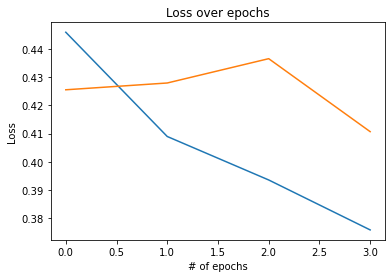

In [12]:
# plot loss
plt.plot(np.arange(0, len(train_losses_eff), 1), train_losses_eff, label='Train')
plt.plot(np.arange(0, len(valid_losses_eff), 1), valid_losses_eff, label='Valid')
plt.ylabel('Loss')
plt.xlabel('# of epochs')
plt.title('Loss over epochs')
plt.show()

In [13]:
# Save Model
torch.save(op_model, 'C:\\Users\\Admin\\Git\\SIIM\\models\\EfficientNETB2-4\\model.pth')